I study the apparent proper motion of radio sources to estimate the ICRF axis stability.

In [1]:
import matplotlib.pyplot as plt
# from matplotlib.ticker import MultipleLocator
import numpy as np
import statsmodels.api as sm
from astropy.time import Time
from astropy.table import Table, join

from statsmodels.iolib.table import (SimpleTable, default_txt_fmt)
import seaborn as sns

from myprogs.StatsFunc.rms_calc import rms_calc
from myprogs.catalog.ga_func import glide_apex_calc

In [2]:
icrf3_def = Table.read("../data/icrf3sx-def-sou.txt", format="ascii")

In [3]:
def nor_pm_calc(pmra, pmra_err, pmdec, pmdec_err, pm_ra_dec_cor):
    """pm_ra_dec_coralculate the normalized seperation.

    Parameters
    ----------
    pmra/pmdec : proper motion in Right Ascension / Declination
    pmra_err/pmdec_err : formal uncertainty of pmra*cos(Dec)/pmdec
    pm_ra_dec_cor : correlation coeffient between pmra*cos(Dec) and pmdec.

    Returns
    ----------
    X : Normalized proper motion, unit-less.
    """

    # Total proper motion
    pm = np.sqrt(pmra**2+pmdec**2)

    # Normalised coordinate difference
    X_a = pmra / pmra_err
    X_d = pmdec / pmdec_err

    # Normalised separation - Mignard's statistics (considering covariance)
    # Now I will use the explict expression
    # Avoid singular
    pm_ra_dec_cor = np.where(pm_ra_dec_cor == -1, -0.99999, pm_ra_dec_cor)
    pm_ra_dec_cor = np.where(pm_ra_dec_cor == 1, 0.99999, pm_ra_dec_cor)
    X = np.sqrt((X_a**2 + X_d**2 - 2 * pm_ra_dec_cor * X_a * X_d) /
                (1 - pm_ra_dec_cor**2))

    return X_a, X_d, X, pm


def nor_pm_calc_4_table(tab):

    pmra = tab["pmra"]
    pmra_err = tab["pmra_err"]
    pmdec = tab["pmdec"]
    pmdec_err = tab["pmdec_err"]
    pm_ra_dec_cor = tab["pmra_pmdec_cor"]

    X_a, X_d, X, pm = nor_pm_calc(pmra, pmra_err, pmdec, pmdec_err,
                                  pm_ra_dec_cor)

    return X_a, X_d, X, pm

# 1 Distribution of the APM

In [4]:
apm_tab = Table.read("../data/ts_nju_pm_fit_3sigma-10step.dat", format="ascii.csv")

# convert mas/yr into muas/yr
apm_tab["pmra"] = apm_tab["pmra"] * 1e3
apm_tab["pmra_err"] = apm_tab["pmra_err"] * 1e3
apm_tab["pmdec"] = apm_tab["pmdec"] * 1e3
apm_tab["pmdec_err"] = apm_tab["pmdec_err"] * 1e3

Remove sources without apparant proper motion estimate.

In [5]:
mask = apm_tab["num_cln"] >= 5
apm_tab = apm_tab[mask]

Estimate the empirical cumulative probability function.

In [6]:
ecdf_pmra = sm.distributions.ECDF(apm_tab["pmra"])
ecdf_pmdec = sm.distributions.ECDF(apm_tab["pmdec"])

For the ICRF3 defining sources.

In [7]:
apm_def = join(icrf3_def, apm_tab, keys="iers_name")

In [8]:
ecdf_pmra_def = sm.distributions.ECDF(apm_def["pmra"])
ecdf_pmdec_def = sm.distributions.ECDF(apm_def["pmdec"])

Make the plot.

In [9]:
bin_array = np.arange(-100, 100, 5)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


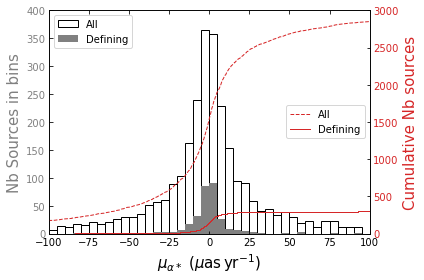

In [10]:
fig, ax1 = plt.subplots()

color = "grey"
ax1.hist(apm_tab["pmra"],
         bins=bin_array,
         color=color,
         fill=False,
         label="All")
ax1.hist(apm_def["pmra"],
         bins=bin_array,
         color=color,
         label="Defining")
ax1.set_xlabel("$\\mu_{\\alpha*}$ ($\mu$as$\,$yr$^{-1}$)", fontsize=15)
ax1.set_ylabel("Nb Sources in bins", color=color, fontsize=15)
ax1.tick_params(axis="y", labelcolor=color)
ax1.axis([-100, 100, 0, 400])
ax1.legend(loc="upper left")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = "tab:red"
ax2.plot(ecdf_pmra.x,
         ecdf_pmra.y * len(apm_tab),
         color=color,
         lw=1,
         ls="--",
         label="All")
ax2.step(ecdf_pmra_def.x,
         ecdf_pmra_def.y * len(apm_def),
         color=color,
         lw=1,
         ls="-",
         label="Defining")
ax2.tick_params(axis="y", labelcolor=color)
ax2.set_ylabel("Cumulative Nb sources", color=color,
               fontsize=15)  # we already handled the x-label with ax1
ax2.axis([-100, 100, 0, 3000])
ax2.legend(loc="center right")

plt.tight_layout()
plt.savefig("../plots/pmra-hist.eps")

In [11]:
per = [0, 5, 10, 25, 50, 75, 90, 95, 100] 
Q = np.percentile(apm_tab["pmra"], per)

line_fmt1 = "  {:8d}" * len(per)
line_fmt2 = "  {:8.2f}" * len(Q)

print("PM in R.A. (muas/yr)")
print("Percentile(%)", line_fmt1.format(*per))
print("             ", line_fmt2.format(*Q))

lim = 30
mask = (np.fabs(apm_tab["pmra"]) < lim)
print("[-{:2d}, {:2d}]: {:.2f}%".format(lim, lim, len(apm_tab[mask])/len(apm_tab)*100))

PM in R.A. (muas/yr)
Percentile(%)          0         5        10        25        50        75        90        95       100
                -7331.81   -118.27    -58.56    -15.83     -0.30     14.67     58.43    116.60   9753.56
[-30, 30]: 66.06%


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


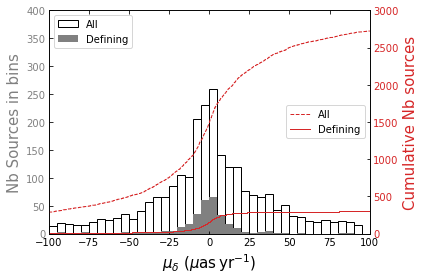

In [12]:
fig, ax1 = plt.subplots()

color = "grey"
ax1.hist(apm_tab["pmdec"],
         bins=bin_array,
         color=color,
         fill=False,
         label="All")
ax1.hist(apm_def["pmdec"],
         bins=bin_array,
         color=color,
         label="Defining")
ax1.set_xlabel("$\\mu_{\\delta}$ ($\mu$as$\,$yr$^{-1}$)", fontsize=15)
ax1.set_ylabel("Nb Sources in bins", color=color, fontsize=15)
ax1.tick_params(axis="y", labelcolor=color)
ax1.axis([-100, 100, 0, 400])
ax1.legend(loc="upper left")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = "tab:red"
ax2.step(ecdf_pmdec.x,
         ecdf_pmdec.y * len(apm_tab),
         color=color,
         lw=1,
         ls="--",
         label="All")
ax2.step(ecdf_pmdec_def.x,
         ecdf_pmdec_def.y * len(apm_def),
         color=color,
         lw=1,
         ls="-",
         label="Defining")
ax2.tick_params(axis="y", labelcolor=color)
ax2.set_ylabel("Cumulative Nb sources", color=color,
               fontsize=15)  # we already handled the x-label with ax1
ax2.axis([-100, 100, 0, 3000])
ax2.legend(loc="center right")

plt.tight_layout()
plt.savefig("../plots/pmdec-hist.eps")

In [13]:
per = [0, 5, 10, 25, 50, 75, 90, 95, 100] 
Q = np.percentile(apm_tab["pmdec"], per)

line_fmt1 = "  {:8d}" * len(per)
line_fmt2 = "  {:8.2f}" * len(Q)

print("PM in decl. (muas/yr)")
print("Percentile(%)", line_fmt1.format(*per))
print("             ", line_fmt2.format(*Q))

lim = 30
mask = (np.fabs(apm_tab["pmdec"]) < lim)
print("[-{:2d}, {:2d}]: {:.2f}%".format(lim, lim, len(apm_tab[mask])/len(apm_tab)*100))

PM in decl. (muas/yr)
Percentile(%)          0         5        10        25        50        75        90        95       100
                -14063.16   -181.99    -94.71    -24.84      0.38     30.32    100.57    199.48  15977.32
[-30, 30]: 52.10%


In [14]:
mean_pmra = np.mean(apm_tab["pmra"])
median_pmra = np.median(apm_tab["pmra"])
std_pmra = np.std(apm_tab["pmra"])

mean_pmdec = np.mean(apm_tab["pmdec"])
median_pmdec = np.median(apm_tab["pmdec"])
std_pmdec = np.std(apm_tab["pmdec"])

/Users/Neo/scisoft/opt64/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [15]:
mean_pmra_def = np.mean(apm_def["pmra"])
median_pmra_def = np.median(apm_def["pmra"])
std_pmra_def = np.std(apm_def["pmra"])

mean_pmdec_def = np.mean(apm_def["pmdec"])
median_pmdec_def = np.median(apm_def["pmdec"])
std_pmdec_def = np.std(apm_def["pmdec"])

In [16]:
se = np.vstack([[len(apm_tab), mean_pmra, median_pmra, std_pmra],
                [len(apm_tab), mean_pmdec, median_pmdec, std_pmdec],
                [len(apm_def), mean_pmra_def, median_pmra_def, std_pmra_def],
                [len(apm_def), mean_pmdec_def, median_pmdec_def, std_pmdec_def]])

se = np.round(se, 2)

colnames = ["#sou", "Mean", "Median", "Std"]
rownames = ["All-RA", "All-Dec", "Def-RA", "Def-Dec"]

tabl = SimpleTable(se, colnames, rownames, txt_fmt=default_txt_fmt)
print(tabl)
print("Unit: muas/yr")

         #sou   Mean Median  Std  
----------------------------------
All-RA  3029.0 -0.63   -0.3 286.35
All-Dec 3029.0 -0.19   0.38 507.65
Def-RA   299.0  0.84  -0.07  18.77
Def-Dec  299.0 -3.77  -0.64   29.6
----------------------------------
Unit: muas/yr


I add some plots to show the siginificance of the apparent proper motion.

In [17]:
x_pmra, x_pmdec, x_pm, pm = nor_pm_calc_4_table(apm_tab)
x_pmra_def, x_pmdec_def, x_pm_def, pm_def = nor_pm_calc_4_table(apm_def)

In [18]:
bin_array = np.arange(-15, 15, 1)

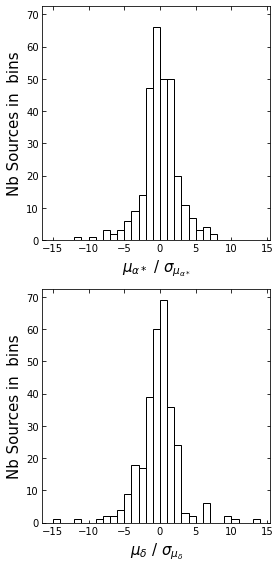

In [19]:
fig, (ax1, ax2) = plt.subplots(figsize=(4, 8), nrows=2, sharey=True)

ax1.hist(x_pmra_def,
         bins=bin_array,
         color=color,
         fill=False)
ax1.set_xlabel("$\\mu_{\\alpha*}$ / $\sigma_{\mu_{\\alpha*}}$", fontsize=15)
ax1.set_ylabel("Nb Sources in  bins", fontsize=15)


ax2.hist(x_pmdec_def,
         bins=bin_array,
         color=color,
         fill=False)
ax2.set_xlabel("$\\mu_{\\delta}$ / $\sigma_{\mu_{\delta}}$", fontsize=15)
ax2.set_ylabel("Nb Sources in  bins", fontsize=15)
# ax1.axis([-100, 100, 0, 400])


plt.tight_layout()


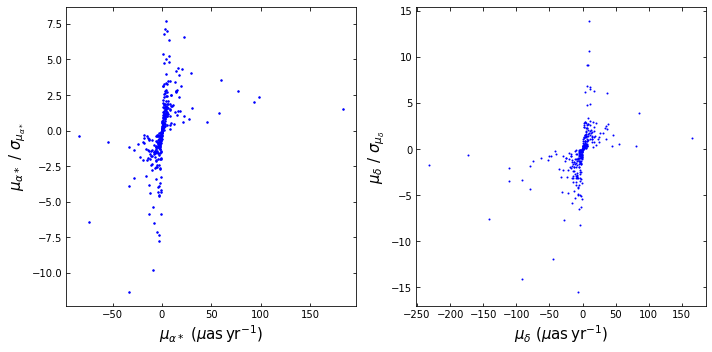

In [20]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)

ax1.plot(apm_def["pmra"], x_pmra_def, "b.", ms=3)
ax2.plot(apm_def["pmdec"], x_pmdec_def, "b.", ms=2)

ax1.set_xlabel("$\\mu_{\\alpha*}$ ($\mu$as$\,$yr$^{-1}$)", fontsize=15)
ax1.set_ylabel("$\\mu_{\\alpha*}$ / $\sigma_{\mu_{\\alpha*}}$", fontsize=15)
    
ax2.set_xlabel("$\\mu_{\delta}$ ($\mu$as$\,$yr$^{-1}$)", fontsize=15)
ax2.set_ylabel("$\\mu_{\delta}$ / $\sigma_{\mu_{\delta}}$", fontsize=15)
    
plt.tight_layout()
plt.savefig("../plots/nor-pm.eps")

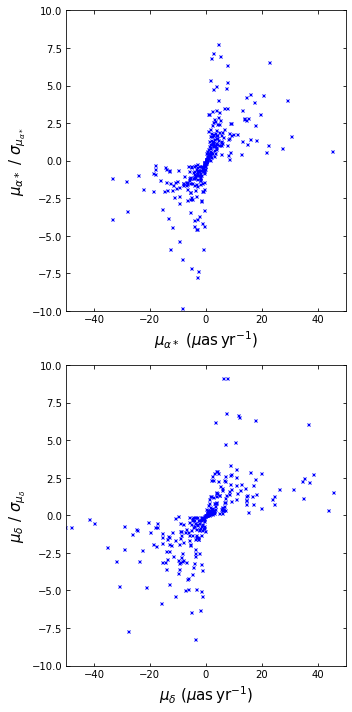

In [21]:
fig, (ax1, ax2) = plt.subplots(figsize=(5, 10), nrows=2)

ax1.plot(apm_def["pmra"], x_pmra_def, "bx", ms=3)
ax2.plot(apm_def["pmdec"], x_pmdec_def, "bx", ms=3)

ax1.set_xlabel("$\\mu_{\\alpha*}$ ($\mu$as$\,$yr$^{-1}$)", fontsize=15)
ax1.set_ylabel("$\\mu_{\\alpha*}$ / $\sigma_{\mu_{\\alpha*}}$", fontsize=15)
    
ax2.set_xlabel("$\\mu_{\delta}$ ($\mu$as$\,$yr$^{-1}$)", fontsize=15)
ax2.set_ylabel("$\\mu_{\delta}$ / $\sigma_{\mu_{\delta}}$", fontsize=15)

ax1.axis([-50, 50, -10, 10])
ax2.axis([-50, 50, -10, 10])
    
plt.tight_layout()
plt.savefig("../plots/nor-pm-zoomin.eps")

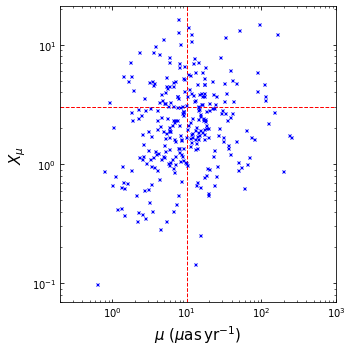

In [22]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.hlines(3, 0.2, 1000, "r", ls="dashed", lw=1)
ax.vlines(10, 0.07, 21, "r", ls="dashed", lw=1)
ax.plot(pm_def, x_pm_def, "bx", ms=3)

ax.set_xlabel("$\\mu$ ($\mu$as$\,$yr$^{-1}$)", fontsize=15)
ax.set_ylabel("$X_\\mu$ ", fontsize=15)
    
ax.axis([0.2, 1000, 0.07, 21])
ax.set_yscale("log")
ax.set_xscale("log")
    
plt.tight_layout()
plt.savefig("../plots/nor-pm-def.eps")

In [23]:
per = [0, 5, 10, 25, 50, 75, 90, 95, 100] 
Q = np.percentile(pm, per)

line_fmt1 = "  {:8d}" * len(per)
line_fmt2 = "  {:8.2f}" * len(Q)

print("Total PM for all sources (muas/yr)")
print("Percentile(%)", line_fmt1.format(*per))
print("             ", line_fmt2.format(*Q))

lim = 30
mask = (np.fabs(pm) < lim)
print("[-{:2d}, {:2d}]: {:.2f}%".format(lim, lim, len(apm_tab[mask])/len(apm_tab)*100))

lim = 10
mask = (np.fabs(pm) < lim)
print("[-{:2d}, {:2d}]: {:.2f}%".format(lim, lim, len(apm_tab[mask])/len(apm_tab)*100))

Total PM for all sources (muas/yr)
Percentile(%)          0         5        10        25        50        75        90        95       100
                    0.36      3.89      6.48     15.34     38.42    100.40    243.18    452.19  16190.48
[-30, 30]: 42.79%
[-10, 10]: 16.54%


In [24]:
per = [0, 5, 10, 25, 50, 75, 90, 95, 100] 
Q = np.percentile(pm_def, per)

line_fmt1 = "  {:8d}" * len(per)
line_fmt2 = "  {:8.2f}" * len(Q)

print("Total PM for defining sources (muas/yr)")
print("Percentile(%)", line_fmt1.format(*per))
print("             ", line_fmt2.format(*Q))

lim = 30
mask = (np.fabs(pm_def) < lim)
print("[-{:2d}, {:2d}]: {:.2f}%".format(lim, lim, len(apm_def[mask])/len(apm_def)*100))

lim = 10
mask = (np.fabs(pm_def) < lim)
print("[-{:2d}, {:2d}]: {:.2f}%".format(lim, lim, len(apm_def[mask])/len(apm_def)*100))

Total PM for defining sources (muas/yr)
Percentile(%)          0         5        10        25        50        75        90        95       100
                    0.63      1.64      2.52      4.75      8.84     16.95     36.20     64.54    247.00
[-30, 30]: 86.62%
[-10, 10]: 53.85%


In [25]:
lim = 3
mask1 = np.fabs(x_pmra_def) > lim
mask2 = np.fabs(x_pmdec_def) > lim
mask3 = x_pm_def > lim

print("Significance of PM > {:d}-sigma level".format(lim))
print("RA:       {:.2f}%".format(len(apm_def[mask1])/len(apm_def)*100))
print("decl:     {:.2f}%".format(len(apm_def[mask2])/len(apm_def)*100))
print("Total:    {:.2f}%".format(len(apm_def[mask3])/len(apm_def)*100))

lim2 = 10

mask1 = ((np.fabs(x_pmra_def) > lim)&(np.fabs(apm_def["pmra"]) > lim2))
mask2 = ((np.fabs(x_pmdec_def) > lim)&(np.fabs(apm_def["pmdec"]) > lim2))
mask3 = ((x_pm_def > lim)&(pm_def > lim2))

print("For the subset of mu > {:d} muas/yr".format(lim2))
print("RA:       {:.2f}%".format(len(apm_def[mask1])/len(apm_def)*100))
print("decl:     {:.2f}%".format(len(apm_def[mask2])/len(apm_def)*100))
print("Total:    {:.2f}%".format(len(apm_def[mask3])/len(apm_def)*100))

Significance of PM > 3-sigma level
RA:       17.39%
decl:     18.06%
Total:    33.78%
For the subset of mu > 10 muas/yr
RA:       5.69%
decl:     8.70%
Total:    17.39%


# 2. Global spin from the ICRF3-defining source subset

In [26]:
from tool_func import vsh_fit_for_pm, vsh_fit_for_pm2

In [27]:
pmt, sig, output = vsh_fit_for_pm(apm_def)
pmt1, sig1, output1 = vsh_fit_for_pm2(apm_def)

In [28]:
se = np.vstack((pmt[:4], sig[:4], pmt1, sig1)).T
se = np.round(se, 2)

colnames = ["Full", "+/-", "Rotation", "+/-"]
rownames = ["Rx", "Ry", "Rz", "R"]

tabl = SimpleTable(se, colnames, rownames, txt_fmt=default_txt_fmt)
print(tabl)

se = np.vstack((pmt[4:], sig[4:])).T
se = np.round(se, 2)

colnames = ["Glide", "+/-"]
rownames = ["Gx", "Gy", "Gz", "G"]

tabl = SimpleTable(se, colnames, rownames, txt_fmt=default_txt_fmt)
print(tabl)

print("Unit: muas/yr")
print("Number of sources used in the fitting is", len(apm_def))

    Full +/-  Rotation +/- 
---------------------------
Rx -0.77 0.27    -0.42 0.23
Ry  0.52 0.32     0.64 0.28
Rz -0.09 0.21    -0.16 0.21
R   0.93 0.29     0.78 0.26
---------------------------
   Glide +/- 
-------------
Gx   0.2 0.23
Gy -0.73 0.27
Gz -1.01 0.28
G   1.26 0.28
-------------
Unit: muas/yr
Number of sources used in the fitting is 299


In [29]:
print("Apex for rotation (deg)")
print("      Full      Rotation")
print("RA : {:3.0f} +/- {:3.0f}  {:3.0f} +/- {:3.0f}".format(
    output["R_ra"], output["R_ra_err"], output1["R_ra"], output1["R_ra_err"]))
print("Dec: {:3.0f} +/- {:3.0f}  {:3.0f} +/- {:3.0f}".format(
    output["R_dec"], output["R_dec_err"], output1["R_dec"],
    output1["R_dec_err"]))

print("Apex for glide (deg)")
print("      Glide")
print("RA : {:3.0f} +/- {:3.0f}  ".format(
    output["G_ra"], output["G_ra_err"]))
print("Dec: {:3.0f} +/- {:3.0f}".format(
    output["G_dec"], output["G_dec_err"]))

Apex for rotation (deg)
      Full      Rotation
RA : 146 +/-  19  123 +/-  18
Dec:  -6 +/-  13  -11 +/-  16
Apex for glide (deg)
      Glide
RA : 285 +/-  18  
Dec: -53 +/-  12
